# Appendix A: Universal Function Approximation

In [4]:
import jax.numpy as np
import jax
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
import ADAMLL as ada

## Data
the `xor` function is a binary function that returns `1` if the inputs are different and `0` if the inputs are the same. The `xor` function is not linearly separable, so it cannot be represented by a single perceptron. However, it can be represented by a neural network with two layers. The first layer is a hidden layer with two perceptrons. The second layer is an output layer with one perceptron. The following code defines the `xor` function and plots the data.
As we hinted at in the introduction, there may be a way for a logistic regression model to represent the `xor` function, by fitting a polynomial to the data.

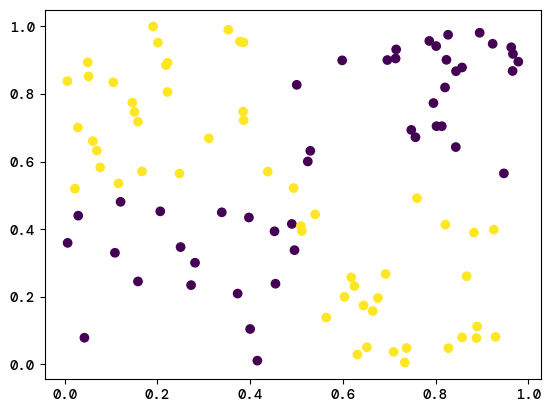

In [5]:
key = jax.random.PRNGKey(0)
x = jax.random.uniform(key,(100,2))
t_xor = (x[:,0] >= 0.5) ^ (x[:,1] > 0.5)
######## PLOT XOR #############################
plt.scatter(x[:,0],x[:,1],c=t_xor)
plt.show()

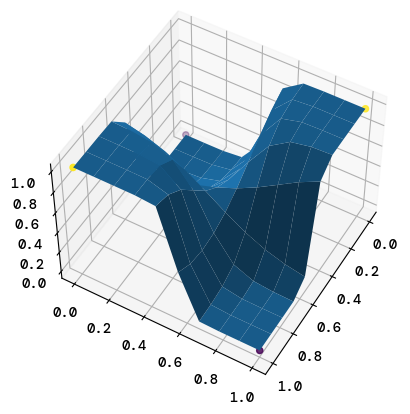

In [8]:

binary_xor = np.array([[0,0],[0,1],[1,0],[1,1]])
binary_target = np.array([0,1,1,0])


poly = PolynomialFeatures(3)
data = poly.fit_transform(x)

def fit(x,target):
    w = np.ones((x.shape[1],1))
    eta = 0.1
    for _ in range(1000):
        z = np.dot(x,w)
        y = ada.activations.sigmoid(z)
        e = y - target
        w -= eta * np.dot(x.T,e)
    return w



X = np.linspace(0,1,10)
Y = np.linspace(0,1,10)
X,Y = np.meshgrid(X,Y)
w = fit(data,t_xor.reshape(-1,1))
g = np.concatenate((X.ravel().reshape(-1,1),Y.ravel().reshape(-1,1)),axis=1)
g = poly.fit_transform(g)
Z = np.dot(g,w)
Z = Z.reshape(10,10)
Z = ada.activations.sigmoid(Z)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,Z)
ax.view_init(50, 30)
ax.scatter(binary_xor[:,0],binary_xor[:,1],binary_target, c=binary_target)
plt.show()

In [11]:



plt.figure()



# regresion one hidden layer
# dimension [1,2,1] 
np.random.seed(0)
params = [{'w':np.random.randn(1,4),'b':np.random.randn(1,4)},{'w':np.random.randn(4,1),'b':np.random.randn(1,1)}]

def forward(x,params):
    z1 = np.dot(x,params[0]['w']) + params[0]['b']
    a1 = relu(z1)
    z2 = np.dot(a1,params[1]['w']) + params[1]['b']
    a2 = z2
    return a2




# tune manually
# params[0]['w'] = np.array([[-0.5],[1],[1]]).reshape(1,3)
# params[0]['b'] = np.array([[-1.0],[0.],[-2.]]).reshape(1,3)
# params[1]['w'] = np.array([[-6.],[-2.],[0.5]]).reshape(3,1)
# params[1]['b'] = np.array([[1.]]).reshape(1,1)


# mean square error
def mse(y,t):
    return np.mean((y-t)**2)

def relu_derivative(x):
    return np.where(x>=0,1,0)

def sigmoid_derivative(x):
    return sigmoid(x) * (1-sigmoid(x))

def fit(x,target,params):
    N = x.shape[0]
    eta = 0.04
    t = target
    for _ in range(10000):
        W1 = params[0]['w'] 
        b1 = params[0]['b']
        W2 = params[1]['w']
        b2 = params[1]['b']

        if not np.isfinite(W1).all() or not np.isfinite(W2).all():
            # clip weights
            W1 = np.clip(W1, -100, 100)
            W2 = np.clip(W2, -100, 100)
            print('weights clipped')

        if not np.isfinite(b1).all() or not np.isfinite(b2).all():
            # clip biases
            b1 = np.clip(b1, -100, 100)
            b2 = np.clip(b2, -100, 100)
            print('biases clipped')


        Z1 = x.dot(W1) + b1
        H = relu(Z1)
        # H = sigmoid(Z1)
        Y = H.dot(W2) + b2
# Compute output error
        error = Y - t
# Backward pass (compute gradients)
        grad_W2 = H.T.dot(error) / N
        grad_b2 = np.sum(error, axis=0, keepdims=True) / N
        grad_H = error.dot(W2.T)
        # grad_Z1 = grad_H * sigmoid_derivative(Z1)
        grad_Z1 = grad_H * relu_derivative(Z1)
        grad_W1 = x.T.dot(grad_Z1) / N
        grad_b1 = np.sum(grad_Z1, axis=0, keepdims=True) / N

        params[0]['w'] -= eta * grad_W1
        params[0]['b'] -= eta * grad_b1
        params[1]['w'] -= eta * grad_W2
        params[1]['b'] -= eta * grad_b2
    return params


x = np.linspace(-4,4,100)
t = -0.1*x**2
t = t - np.mean(t)
plt.plot(x,t)



params = fit(x.reshape(-1,1),t.reshape(-1,1),params)



# plot first layer activation
z1 = np.dot(x.reshape(-1,1),params[0]['w']) + params[0]['b']
a1 = relu(z1)
plt.plot(x,a1)


y = forward(x.reshape(-1,1),params)
plt.plot(x,y)
plt.show()

